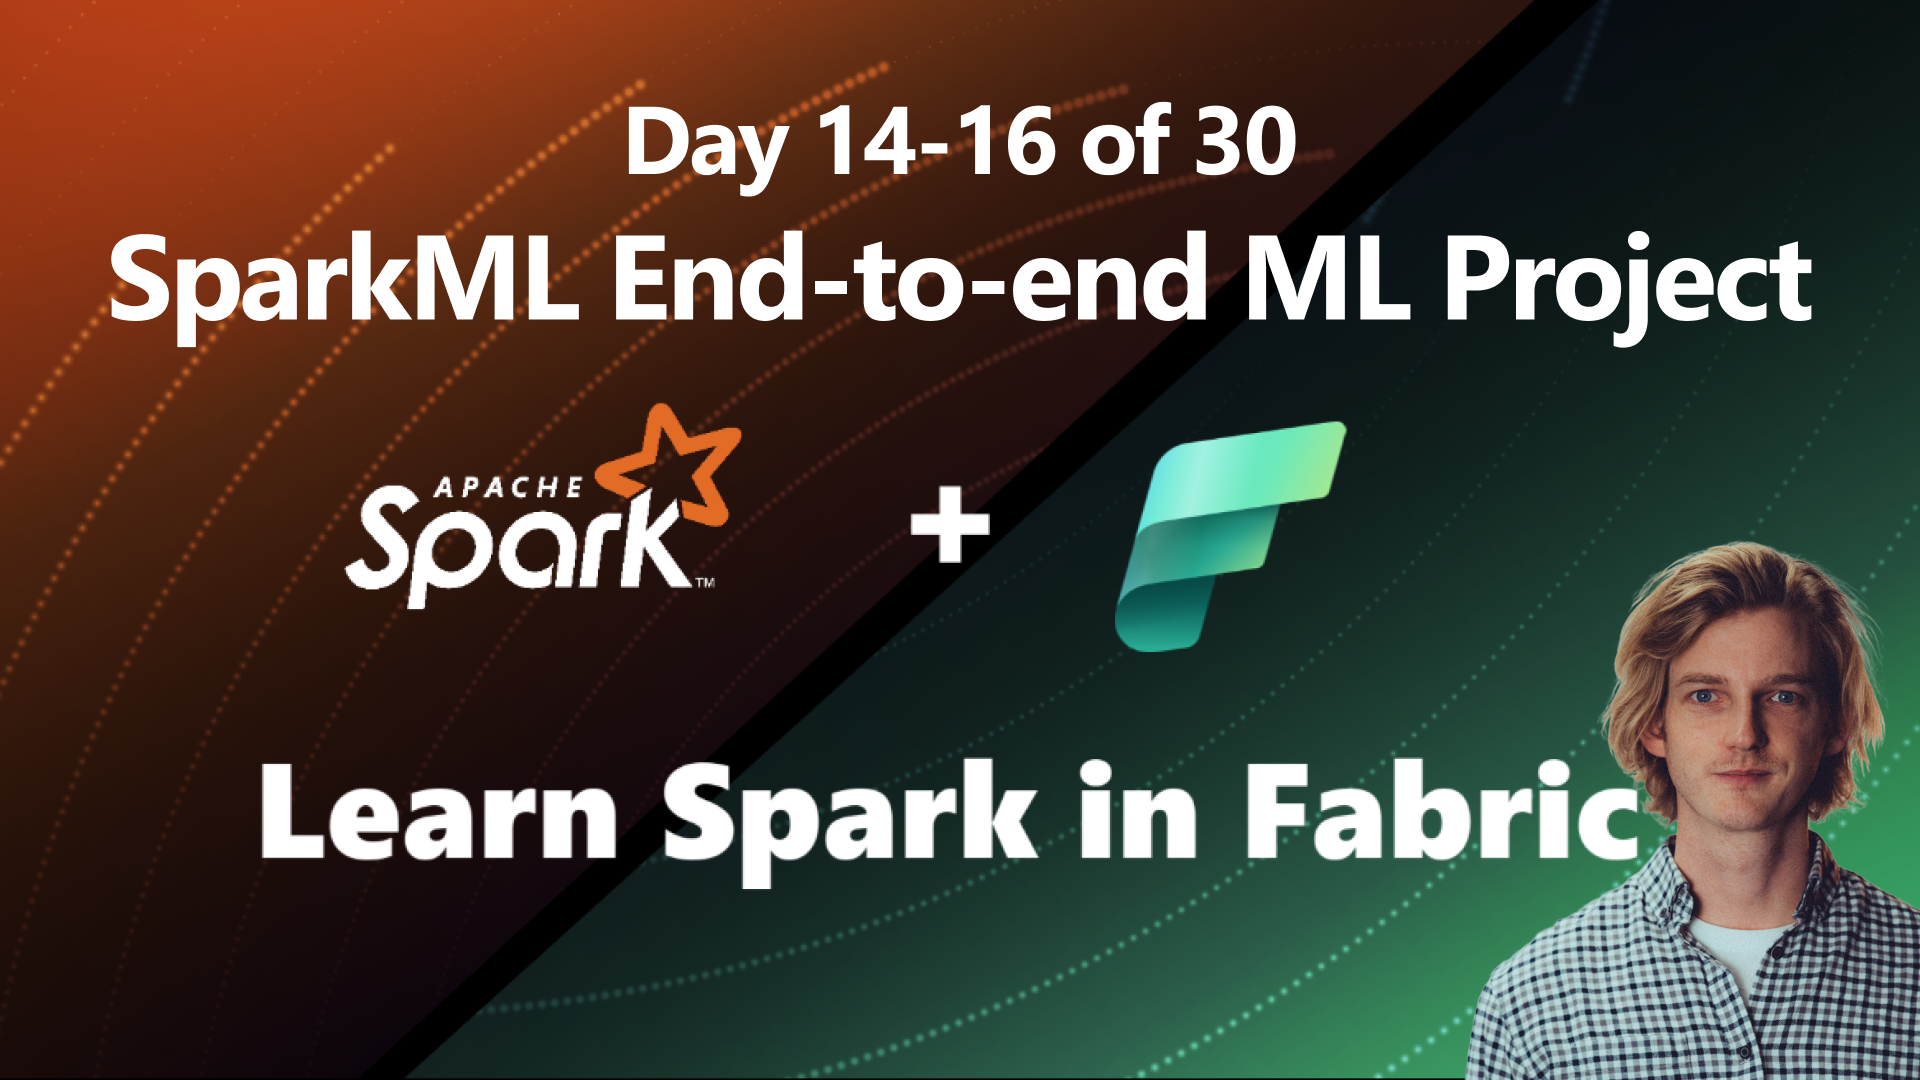
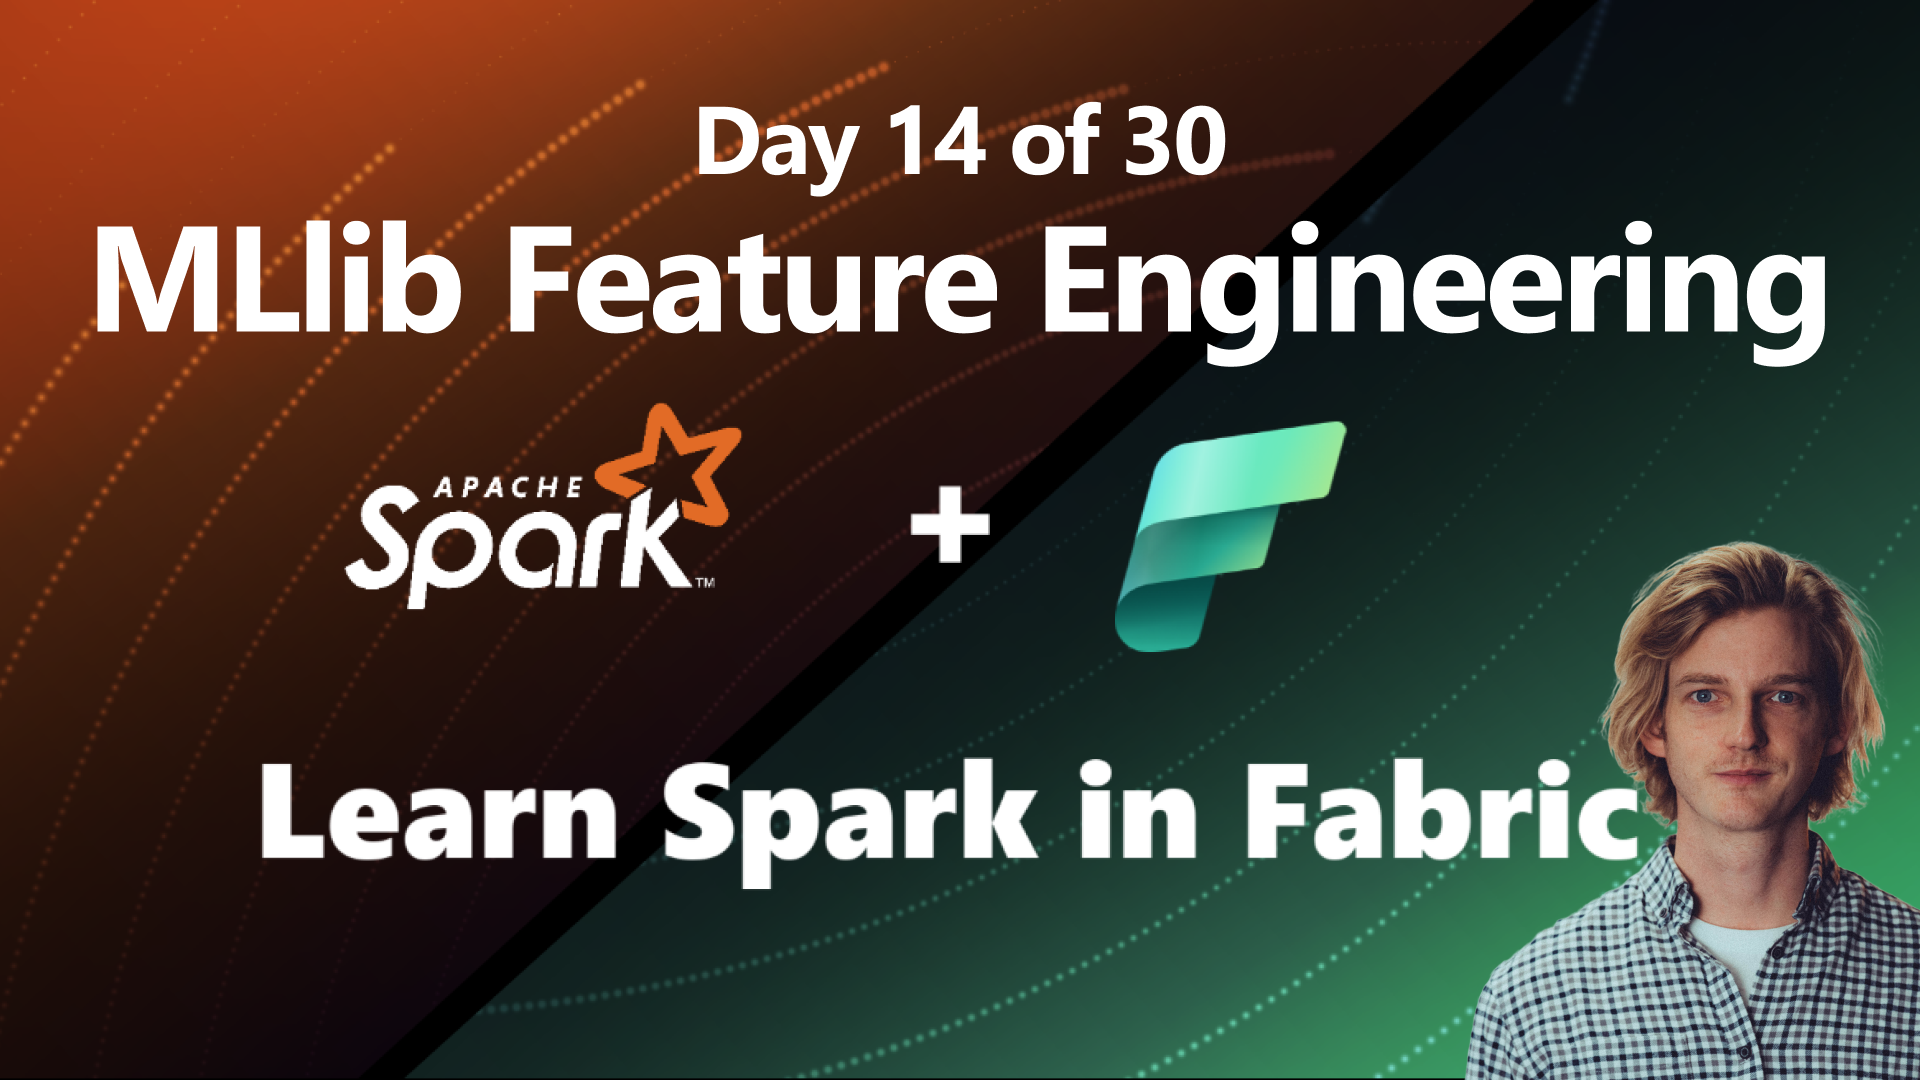

#### What is SparkML? 

SparkML is Apache Spark's scalable machine learning library.

It allows us to perform machine learning on large-scale datasets. 



#### 

## Introduction to the task 
This dataset is from [Kaggle](https://www.kaggle.com/datasets/dineshpiyasamara/sentiment-analysis-dataset). 

It contains 7918 tweets mostly about mobile phones/ brands, with labels on their sentiment. 

A Label of 0 means the text is positive/ neutral. 

A label of 1 means the tweet contains negative sentiment.  

Our goal is to build a simple machine learning training pipeline to 
correctly predict the sentiment of a given tweet.

This notebook covers: 
- basic feature extraction and feature engineering for text data
- building a Pipeline
- training a Logistic Regression model
- evaluating our model 
- visualizing the results 


## Reading in the data, train/ test split
To begin, you will need to download the data from [here](https://www.kaggle.com/datasets/dineshpiyasamara/sentiment-analysis-dataset), and upload it to the Lakehouse Files area.  


In [ ]:
tweet_schema = "id int, label double, tweet string"

tweets_df = spark.read.csv(header=True, schema=tweet_schema, path="Files/sentiment_analysis.csv")

display(tweets_df.head(3))

# train test split 
training_data, test_data = tweets_df.randomSplit([0.8, 0.2], seed=33)

print('Training Data: ', training_data.count())
print('Test data: ', test_data.count())

## Machine Learning Pipeline Construction


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression

# from our tweet, create a list of works (tokens) 
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")

# map the sequence of words to their term frequency  
hashing_term_frequency = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)

# calculate the IDF for each TF mapping (i.e. how rare is that term in the whole dataset?)
inverse_doc_frequency = IDF(inputCol="rawFeatures", outputCol="features")

# Create a new logistic regression object for the model
log_regression_model = LogisticRegression(maxIter=10, regParam=0.3, labelCol = 'label')

# Construct pipeline, and fit to training data
lr_pipeline = Pipeline(stages=[tokenizer, hashing_term_frequency, inverse_doc_frequency, log_regression_model]).fit(training_data)

## Model evaluation

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def test_and_viz(lr_pipeline): 

    # model evaluation
    predictions = lr_pipeline.transform(test_data)
    predictionAndLabels = predictions.select("label", "prediction").rdd
    metrics = BinaryClassificationMetrics(predictionAndLabels)
    print("Area under ROC = %s" % metrics.areaUnderROC)

    import matplotlib.pyplot as plt
    ## Plot the ROC curve; no need for pandas, because this uses the modelSummary object
    modelSummary = lr_pipeline.stages[-1].summary

    plt.plot([0, 1], [0, 1], 'r--')
    plt.plot(modelSummary.roc.select('FPR').collect(),
            modelSummary.roc.select('TPR').collect())
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

test_and_viz(lr_pipeline)

#### 